In [ ]:
#default_exp vision.core
#default_cls_lvl 3

In [ ]:
#export
from local.torch_basics import *
from local.test import *
from local.data.all import *
from local.notebook.showdoc import show_doc

from PIL import Image

In [ ]:
#export
_all_ = ['Image','ToTensor']

In [ ]:
#It didn't use to be necessary to add ToTensor in all but we don't have the encodes methods defined here otherwise.
#TODO: investigate

# Core vision
> Basic image opening/processing functionality

## Helpers

In [ ]:
im = Image.open(TEST_IMAGE).resize((30,20))

In [ ]:
#export
@patch_property
def n_px(x: Image.Image): return x.size[0] * x.size[1]

#### `Image.n_px`

> `Image.n_px` (property)

Number of pixels in image

In [ ]:
test_eq(im.n_px, 30*20)

In [ ]:
#export
@patch_property
def shape(x: Image.Image): return x.size[1],x.size[0]

#### `Image.shape`

> `Image.shape` (property)

Image (height,width) tuple (NB: opposite order of `Image.size()`, same order as numpy array and pytorch tensor)

In [ ]:
test_eq(im.shape, (20,30))

In [ ]:
#export
@patch_property
def aspect(x: Image.Image): return x.size[0]/x.size[1]

#### `Image.aspect`

> `Image.aspect` (property)

Aspect ratio of the image, i.e. `width/height`

In [ ]:
test_eq(im.aspect, 30/20)

In [ ]:
#export
@patch
def reshape(x: Image.Image, h, w, resample=0):
    "`resize` `x` to `(w,h)`"
    return x.resize((w,h), resample=resample)

In [ ]:
show_doc(Image.Image.reshape)

<h4 id="<code>Image.reshape</code>" class="doc_header"><code>Image.reshape</code><a href="https://github.com/fastai/fastai_docs/tree/master/dev/__main__.py#L2" class="source_link" style="float:right">[source]</a></h4>

> <code>Image.reshape</code>(**`x`**:`Image`, **`h`**, **`w`**, **`resample`**=*`0`*)

`resize` `x` to `(w,h)`

In [ ]:
test_eq(im.reshape(12,10).shape, (12,10))

In [ ]:
#export
@patch
def resize_max(x: Image.Image, resample=0, max_px=None, max_h=None, max_w=None):
    h,w = x.shape
    if max_px and x.n_px>max_px: h,w = h*max_px/x.n_px,w*max_px/x.n_px
    if max_h and h>max_h: h,w = h*max_h/h,w*max_h/h
    if max_w and w>max_w: h,w = h*max_w/w,w*max_w/w
    return x.reshape(round(h), round(w), resample=resample)

In [ ]:
test_eq(im.resize_max(max_px=30*20).size, (30,20))
test_eq(im.resize_max(max_px=30*20/2).size, (15,10))
test_eq(im.resize_max(max_px=500, max_h=10, max_w=20).size, (15,10))
test_eq(im.resize_max(max_px=500, max_h=14, max_w=15).size, (15,10))
test_eq(im.resize_max(max_px=30*20/2, max_h=16, max_w=25).size, (15,10))

In [ ]:
#TODO function to resize_max all images in a path (optionally recursively) and save them somewhere (same relative dirs if recursive)

## Basic types

This section regroups the basic types used in vision with the transform that create objects of those types.

In [ ]:
# TODO: docs

In [ ]:
#export
def load_image(fn, mode=None, **kwargs):
    "Open and load a `PIL.Image` and convert to `mode`"
    im = Image.open(fn, **kwargs)
    im.load()
    im = im._new(im.im)
    return im.convert(mode) if mode else im

In [ ]:
#export
class PILBase(Image.Image, metaclass=BypassNewMeta):
    default_dl_tfms = ByteToFloatTensor
    _show_args = {'cmap':'viridis'}
    _open_args = {'mode': 'RGB'}
    @classmethod
    def create(cls, fn, **kwargs)->None:
        "Open an `Image` from path `fn`"
        return cls(load_image(fn, **merge(cls._open_args, kwargs)))

    def show(self, ctx=None, **kwargs):
        "Show image using `merge(self._show_args, kwargs)`"
        return show_image(self, ctx=ctx, **merge(self._show_args, kwargs))

In [ ]:
#export
class PILImage(PILBase): pass

In [ ]:
#export
class PILImageBW(PILImage): _show_args,_open_args = {'cmap':'Greys'},{'mode': 'L'}

In [ ]:
im = PILImage.create(TEST_IMAGE)
test_eq(type(im), PILImage)
test_eq(im.mode, 'RGB')

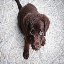

In [ ]:
im.resize((64,64))

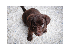

In [ ]:
ax = im.show(figsize=(1,1))

In [ ]:
test_fig_exists(ax)

In [ ]:
#export
class PILMask(PILBase): _open_args,_show_args = {'mode':'L'},{'alpha':0.5, 'cmap':'tab20'}

In [ ]:
im = PILMask.create(TEST_IMAGE)
test_eq(type(im), PILMask)
test_eq(im.mode, 'L')

### Images

In [ ]:
mnist = untar_data(URLs.MNIST_TINY)
fns = get_image_files(mnist)
mnist_fn = fns[0]; mnist_fn

PosixPath('/home/jhoward/git/fastai_dev/dev/data/mnist_tiny/train/3/8055.png')

In [ ]:
timg = Transform(PILImageBW.create)
mnist_img = timg(mnist_fn)
test_eq(mnist_img.size, (28,28))
assert isinstance(mnist_img, PILImageBW)
mnist_img

### Segmentation masks

In [ ]:
camvid = untar_data(URLs.CAMVID_TINY)
fns = get_image_files(camvid)
cam_fn = fns[0]
mask_fn = camvid/'labels'/f'{cam_fn.stem}_P{cam_fn.suffix}'

In [ ]:
cam_img = timg(cam_fn)
test_eq(cam_img.size, (128,96))
tmask = Transform(PILMask.create)
mask = tmask(mask_fn)
test_eq(type(mask), PILMask)
test_eq(mask.size, (128,96))

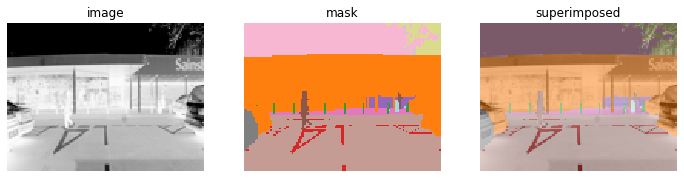

In [ ]:
_,axs = plt.subplots(1,3, figsize=(12,3))
cam_img.show(ctx=axs[0], title='image')
mask.show(alpha=1, ctx=axs[1], vmin=1, vmax=30, title='mask')
cam_img.show(ctx=axs[2], title='superimposed')
mask.show(ctx=axs[2], vmin=1, vmax=30);

### Points

In [ ]:
# export
class TensorPoint(TensorBase):
    "Basic type for points in an image"
    _show_args = dict(s=10, marker='.', c='r')

    @classmethod
    def create(cls, t)->None:
        "Convert an array or a list of points `t` to a `Tensor`"
        return cls(tensor(t).view(-1, 2).float())

    def show(self, ctx=None, **kwargs):
        if 'figsize' in kwargs: del kwargs['figsize']
        ctx.scatter(self[:, 0], self[:, 1], **{**self._show_args, **kwargs})
        return ctx

Points are expected to come as an array/tensor of shape `(n,2)` or as a list of lists with two elements. Unless you change the defaults in `PointScaler` (see later on), coordinates should go from 0 to width/height, with the first one being the column index (so from 0 to width) and the second one being the row index (so from 0 to height).

> Note: This is differnt from the usual indeixing convention for arrays in numpy or in PyTorch, but it's the way points are expected by matplotlib or the internal functions in PyTorch like `F.grid_sample`.

In [ ]:
pnt_img = TensorImage(mnist_img.resize((28,35)))
pnts = np.array([[0,0], [0,35], [28,0], [28,35], [9, 17]])
tfm = Transform(TensorPoint.create)
tpnts = tfm(pnts)
test_eq(tpnts.shape, [5,2])
test_eq(tpnts.dtype, torch.float32)

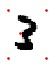

In [ ]:
ctx = pnt_img.show(figsize=(1,1), cmap='Greys')
tpnts.show(ctx=ctx);

### Bounding boxes

In [ ]:
# export
def get_annotations(fname, prefix=None):
    "Open a COCO style json in `fname` and returns the lists of filenames (with maybe `prefix`) and labelled bboxes."
    annot_dict = json.load(open(fname))
    id2images, id2bboxes, id2cats = {}, collections.defaultdict(list), collections.defaultdict(list)
    classes = {o['id']:o['name'] for o in annot_dict['categories']}
    for o in annot_dict['annotations']:
        bb = o['bbox']
        id2bboxes[o['image_id']].append([bb[0],bb[1], bb[0]+bb[2], bb[1]+bb[3]])
        id2cats[o['image_id']].append(classes[o['category_id']])
    id2images = {o['id']:ifnone(prefix, '') + o['file_name'] for o in annot_dict['images'] if o['id'] in id2bboxes}
    ids = list(id2images.keys())
    return [id2images[k] for k in ids], [(id2bboxes[k], id2cats[k]) for k in ids]

In [ ]:
#hide
#TODO explain and/or simplify this
coco = untar_data(URLs.COCO_TINY)
images, lbl_bbox = get_annotations(coco/'train.json')
annots = json.load(open(coco/'train.json'))
test_eq(images, [k['file_name'] for k in annots['images']])
for _ in range(5):
    idx = random.randint(0, len(images)-1)
    fn = images[idx]
    i = 0
    while annots['images'][i]['file_name'] != fn: i+=1
    img_id = annots['images'][i]['id']
    bbs = [ann for ann in annots['annotations'] if ann['image_id'] == img_id]
    i2o = {k['id']:k['name'] for k in annots['categories']}
    lbls = [i2o[bb['category_id']] for bb in bbs]
    bboxes = [bb['bbox'] for bb in bbs]
    bboxes = [[bb[0],bb[1], bb[0]+bb[2], bb[1]+bb[3]] for bb in bboxes]
    test_eq(lbl_bbox[idx], [bboxes, lbls])

In [ ]:
# export
from matplotlib import patches, patheffects

def _draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(linewidth=lw, foreground='black'), patheffects.Normal()])

def _draw_rect(ax, b, color='white', text=None, text_size=14, hw=True, rev=False):
    lx,ly,w,h = b
    if rev: lx,ly,w,h = ly,lx,h,w
    if not hw: w,h = w-lx,h-ly
    patch = ax.add_patch(patches.Rectangle((lx,ly), w, h, fill=False, edgecolor=color, lw=2))
    _draw_outline(patch, 4)
    if text is not None:
        patch = ax.text(lx,ly, text, verticalalignment='top', color=color, fontsize=text_size, weight='bold')
        _draw_outline(patch,1)

In [ ]:
# export
class BBox(tuple):
    "Basic type for a list of bounding boxes in an image"
    def show(self, ctx=None, **kwargs):
        for b,l in zip(self.bbox, self.lbl):
            if l != '#bg': _draw_rect(ctx, b, hw=False, text=l)
        return ctx
    @classmethod
    def create(cls, x): return cls(x)

    bbox,lbl = add_props(lambda i,self: self[i])

In [ ]:
# export
class TensorBBox(tuple):
    "Basic type for a tensor of bounding boxes in an image"
    @classmethod
    def create(cls, x): return cls((tensor(x[0]).view(-1, 4).float(), x[1]))

    bbox,lbl = add_props(lambda i,self: self[i])

Bounding boxes are expected to come as tuple with an array/tensor of shape `(n,4)` or as a list of lists with four elements adn a list of corresponding labels. Unless you change the defaults in `BBoxScaler` (see later on), coordinates for each bounding box should go from 0 to height/width, with the following convetion: top, left, bottom, right.

> Note: We use the same convention as for points with y axis being before x.

In [ ]:
coco = untar_data(URLs.COCO_TINY)
images, lbl_bbox = get_annotations(coco/'train.json')
idx=2
coco_fn,bbox = coco/'train'/images[idx],lbl_bbox[idx]
coco_img = timg(coco_fn)

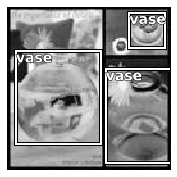

In [ ]:
tbbox = BBox(bbox)
ctx = coco_img.show(figsize=(3,3), cmap='Greys')
tbbox.show(ctx=ctx);

## Basic Transforms

Unless specifically metioned, all the following transforms can be used as single-item transforms (in one of the list in the `tfms` you pass to a `TfmdDS` or a `Datasource`) or tuple transform (in the `tuple_tfms` you pass to a `TfmdDS` or a `Datasource`). The safest way that will work accross applications is to always use them as `tuple_tfms`. For instance, if you have points or bounding boxes as targets and use `ImageResizer` as a single-item transform, when you get to `PointScaler` or `BBoxScaler` (which are tuple transforms) you won't have the correct size of the image to properly scale your points.

In [ ]:
class ImageResizer(Transform):
    order=10
    "Resize image to `size` using `resample"
    def __init__(self, size, resample=Image.BILINEAR):
        if not is_listy(size): size=(size,size)
        self.size,self.resample = (size[1],size[0]),resample

    def encodes(self, o:PILImage): return o.resize(size=self.size, resample=self.resample)
    def encodes(self, o:PILMask):  return o.resize(size=self.size, resample=Image.NEAREST)

`size` can either be one integer (in which case images are resized to a square) or a tuple `height,width`.

> Note: This is the usual convention for arrays or in PyTorch, but it's not the usual convention for PIL Image, which use the other way round.

In [ ]:
f = ImageResizer(14)
test_eq(f(mnist_img).size, (14,14))
test_eq(f(mask).size, (14,14))

f = ImageResizer((32,28))
test_eq(f(mnist_img).size, (28,32))#PIL has width first
test_eq(array(f(mnist_img)).shape, (32,28))#But numpy as height first and that is our convention

In [ ]:
# export
def image2byte(img):
    "Transform image to byte tensor in `c*h*w` dim order."
    res = torch.ByteTensor(torch.ByteStorage.from_buffer(img.tobytes()))
    w,h = img.size
    return res.view(h,w,-1).permute(2,0,1)

In [ ]:
#export
@ToTensor
def encodes(self, o:PILImage): return TensorImage(image2byte(o))
@ToTensor
def encodes(self, o:PILImageBW): return TensorImageBW(image2byte(o))
@ToTensor
def encodes(self, o:PILMask):  return TensorMask(image2byte(o)[0])

Any data augmentation transform that runs on PIL Images must be run before this transform.

In [ ]:
tfm = ToTensor()
test_eq(tfm(mnist_img).shape, (1,28,28))
test_eq(type(tfm(mnist_img)), TensorImageBW)
test_eq(tfm(mask).shape, (96,128))
test_eq(type(tfm(mask)), TensorMask)

Let's confirm we can pipeline this with `PILImage.create`.

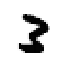

In [ ]:
pipe_img = Pipeline([PILImageBW.create, ToTensor()])
img = pipe_img(mnist_fn)
pipe_img.show(img, figsize=(1,1));

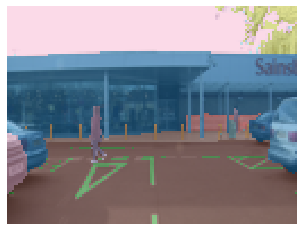

In [ ]:
def _cam_lbl(x): return mask_fn
cam_tds = TfmdDS([cam_fn], [[PILImage.create, ToTensor()], [_cam_lbl, PILMask.create, ToTensor()]])
cam_tds.show_at(0);

In [ ]:
#export
def _scale_pnts(x, y, do_scale=True,y_first=False):
    if y_first: y = y.flip(1)
    sz = [x.shape[-1], x.shape[-2]] if isinstance(x, Tensor) else x.size
    return y * 2/tensor(sz).float() - 1 if do_scale else y

def _unscale_pnts(x, y):
    sz = [x.shape[-1], x.shape[-2]] if isinstance(x, Tensor) else x.size
    return (y+1) * tensor(sz).float()/2

In [ ]:
# export
#TODO: Transform on a whole tuple lose types, see if we can simplify that?
class PointScaler(ItemTransform):
    "Scale a tensor representing points"
    def __init__(self, do_scale=True, y_first=False): self.do_scale,self.y_first = do_scale,y_first
    def encodes(self, o): return (o[0],TensorPoint(_scale_pnts(*o, self.do_scale, self.y_first)))
    def decodes(self, o): return (o[0],TensorPoint(_unscale_pnts(*o)))

TensorPoint.default_ds_tfms = PointScaler

To work with data augmentation, and in particular the `grid_sample` method, points need to be represented with coordinates going from -1 to 1 (-1 being top or left, 1 bottom or right), which will be done unless you pass `do_scale=False`. We also need to make sure they are following our convention of points being x,y coordinates, so pass along `y_first=True` if you have your data in an y,x format to add a flip.

> Warning: This transform needs to run on the tuple level, before any transform that changes the image size.

In [ ]:
def _pnt_lbl(x): return TensorPoint.create(pnts)
def _pnt_open(fn): return PILImage(PILImage.create(fn).resize((28,35)))
pnt_tds = TfmdDS([mnist_fn], [_pnt_open, [_pnt_lbl]])
pnt_tdl = TfmdDL(pnt_tds, bs=1, after_item=[PointScaler(), ToTensor()])

In [ ]:
x,y = pnt_tdl.one_batch()
#Scaling and flipping properly done
test_close(y[0], tensor([[-1., -1.], [-1.,  1.], [1.,  -1.], [1., 1.], [9/14-1, 17/17.5-1]]))
a,b = pnt_tdl.decode_batch((x,y))[0]
test_eq(b, tensor(pnts).float())
#Check types
test_eq(type(x), TensorImage)
test_eq(type(y), TensorPoint)
test_eq(type(a), TensorImage)
test_eq(type(b), TensorPoint)

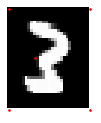

In [ ]:
pnt_tdl.show_batch(figsize=(2,2), cmap='Greys');

In [ ]:
# export
class BBoxScaler(PointScaler):
    "Scale a tensor representing bounding boxes"
    def encodes(self, o):
        x,y = o
        scaled_bb = _scale_pnts(x, y.bbox.view(-1,2), self.do_scale, self.y_first)
        return (x,TensorBBox((scaled_bb.view(-1,4),y.lbl)))

    def decodes(self, o):
        x,y = o
        scaled_bb = _unscale_pnts(x, y.bbox.view(-1,2))
        return (x, TensorBBox((scaled_bb.view(-1,4), y.lbl)))

In [ ]:
# export
class BBoxCategorize(Transform):
    "Reversible transform of category string to `vocab` id"
    order,state_args=1,'vocab'
    def __init__(self, vocab=None):
        self.vocab = vocab
        self.o2i = None if vocab is None else {v:k for k,v in enumerate(vocab)}

    def setup(self, dsrc):
        if not dsrc: return
        dsrc = getattr(dsrc,'train',dsrc)
        vals = set()
        for bb in dsrc: vals = vals.union(set(bb.lbl))
        self.vocab,self.otoi = uniqueify(list(vals), sort=True, bidir=True, start='#bg')

    def encodes(self, o:BBox):
        return TensorBBox.create((o.bbox,tensor([self.otoi[o_] for o_ in o.lbl if o_ in self.otoi])))
    def decodes(self, o:TensorBBox):
        return BBox((o.bbox,[self.vocab[i_] for i_ in o.lbl]))

BBox.default_type_tfms,BBox.default_ds_tfms = BBoxCategorize,BBoxScaler

In [ ]:
#export
#TODO tests
def bb_pad(samples, pad_idx=0):
    "Function that collect `samples` of labelled bboxes and adds padding with `pad_idx`."
    max_len = max([len(s[1][1]) for s in samples])
    def _f(img,bbox,lbl):
        bbox = torch.cat([bbox,bbox.new_zeros(max_len-bbox.shape[0], 4)])
        lbl  = torch.cat([lbl, lbl .new_zeros(max_len-lbl .shape[0])+pad_idx])
        return img,TensorBBox((bbox,lbl))
    return [_f(x,*y) for x,y in samples]

In [ ]:
def _coco_lbl(x): return BBox(bbox)
tcat = BBoxCategorize()
coco_tds = TfmdDS([coco_fn], [PILImage.create, [_coco_lbl, tcat]])
coco_tdl = TfmdDL(coco_tds, bs=1, after_item=[BBoxScaler(), ToTensor()])

In [ ]:
y

tensor([[[-1.0000, -1.0000],
         [-1.0000,  1.0000],
         [ 1.0000, -1.0000],
         [ 1.0000,  1.0000],
         [-0.3571, -0.0286]]])

In [ ]:
x,y = coco_tdl.one_batch()
y0 = y[0][0],y[1][0]
#Scaling and flipping properly done
test_close(y0[0], -1+tensor(bbox[0])/64)
test_eq(y0[1], tensor([1,1,1]))
a,b = coco_tdl.decode_batch((x,y))[0]
test_close(b[0], tensor(bbox[0]).float())
test_eq(b[1], bbox[1])
#Check types
test_eq(type(x), TensorImage)
test_eq(type(y), TensorBBox)
test_eq(type(a), TensorImage)
test_eq(type(b), BBox)

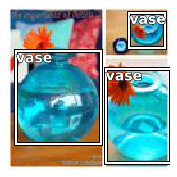

In [ ]:
coco_tdl.show_batch();

# Export -

In [ ]:
#hide
from local.notebook.export import notebook2script
notebook2script(all_fs=True)

Converted 00_test.ipynb.
Converted 01_core.ipynb.
Converted 01a_script.ipynb.
Converted 01a_torch_core.ipynb.
Converted 01c_dataloader.ipynb.
Converted 02_data_transforms.ipynb.
Converted 03_data_pipeline.ipynb.
Converted 05_data_core.ipynb.
Converted 06_data_source.ipynb.
Converted 07_vision_core.ipynb.
Converted 08_pets_tutorial.ipynb.
Converted 09_vision_augment.ipynb.
Converted 11_layers.ipynb.
Converted 11a_vision_models_xresnet.ipynb.
Converted 12_optimizer.ipynb.
Converted 13_learner.ipynb.
Converted 14_callback_schedule.ipynb.
Converted 15_callback_hook.ipynb.
Converted 16_callback_progress.ipynb.
Converted 17_callback_tracker.ipynb.
Converted 18_callback_fp16.ipynb.
Converted 19_callback_mixup.ipynb.
Converted 20_metrics.ipynb.
Converted 21_tutorial_imagenette.ipynb.
Converted 30_text_core.ipynb.
Converted 31_text_data.ipynb.
Converted 32_text_models_awdlstm.ipynb.
Converted 33_test_models_core.ipynb.
Converted 34_callback_rnn.ipynb.
Converted 35_tutorial_wikitext.ipynb.
Conve